# What is this?

**This norebook compares 4 different approaches for recommendations each uses embedding of customers and article generated in the following ways:**

1. Embeddings from products images
1. Embeddings from product text discription
1. Embeddings from prodcut features
1. Embeddings from collaborative filltering model build with TFRS

Customer embeddings are generated by averaging the embeddings of articles in customer purchase history

Data files used here, which can be found in https://www.kaggle.com/datasets/mohammedobeidat/hm-embeddings-4-different-approaches, are generated from different notebooks

Similar items are found using KNN classifier from sklearn and models ares saved in pickle files in data directory

Similarity metric used is dot product (1 - cosine_similarity) and scores are shown over each article image



In [373]:
import pandas as pd
import numpy as np
import pickle
import warnings
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

In [374]:
everthing = pd.read_csv('../input/hm-embeddings-4-different-approaches/everthing.csv')
customer_all = pd.read_csv('../input/hm-embeddings-4-different-approaches/customer_all.csv')
customers_history = pd.read_csv('../input/hm-data-transformation/customer_sequence.csv').set_index('Unnamed: 0')

In [375]:
tfrs_knn = pickle.load(open('../input/hm-embeddings-4-different-approaches/tfrs_knn.pickle', 'rb' ))
image_knn = pickle.load(open('../input/hm-embeddings-4-different-approaches/image_knn.pickle', 'rb'))
text_knn = pickle.load(open('../input/hm-embeddings-4-different-approaches/text_knn.pickle', 'rb'))
feature_knn = pickle.load(open('../input/hm-embeddings-4-different-approaches/feature_knn.pickle', 'rb'))
all_knn = pickle.load(open('../input/hm-embeddings-4-different-approaches/all_knn.pickle', 'rb'))

In [376]:
import matplotlib.pyplot as plt

def plot_items(items, scores=['None']):
    path = "../input/h-and-m-personalized-fashion-recommendations/images"

    k = len(items)
    fig = plt.figure(figsize=(2*k, 10))
    for item, i, score in zip(items, range(1, k+1), scores):
        item = '0'+ str(item)
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = plt.imread(image)
        fig.add_subplot(1, k, i)
        plt.axis('off')
        plt.title(score)
        plt.imshow(image)

In [440]:
def get_rand_article(article_id):
    
    article_mask = everthing.article_id == article_id
    
    combined_article = everthing[article_mask].values[0][1:]
    article_tfrs = everthing[article_mask].filter(regex='^tfrs',axis=1).values
    article_image = everthing[article_mask].filter(regex='^image',axis=1).values
    article_text = everthing[article_mask].filter(regex='^text',axis=1).values
    article_feature = everthing[article_mask].filter(regex='^feature',axis=1).values

    return combined_article, article_tfrs, article_image, article_text, article_feature

In [479]:
def get_rand_customer(customer):
        
    customer = customer_all[customer_all.customer_id == customer].drop('customer_id', axis=1)
    
    customer_tfrs = customer.filter(regex='^tfrs',axis=1)
    customer_image = customer.filter(regex='^image',axis=1)
    customer_text = customer.filter(regex='^text',axis=1)
    customer_feature = customer.filter(regex='^feature',axis=1)
    
    return customer.values[0], customer_tfrs, customer_image, customer_text, customer_feature

In [507]:
def get_new_customer(new_customer_history):
    
    new_customer_embeddings = pd.DataFrame(everthing[everthing.article_id.isin(new_customer_history)].mean()).T
    
    new_tfrs = new_customer_embeddings.filter(regex='^tfrs')
    new_image = new_customer_embeddings.filter(regex='^image')
    new_text = new_customer_embeddings.filter(regex='^text')
    new_feature = new_customer_embeddings.filter(regex='^feature')
    
    return new_customer_embeddings.values[0], new_tfrs, new_image, new_text, new_feature

In [448]:
def get_rcmnds(combined, tfrs, image, text, feature ,k=8):
    
    combined = all_knn.kneighbors([combined], k)
    combined_rcmnds, combined_scores = everthing.iloc[combined[1][0]].article_id.values, np.round(1- combined[0][0], 2)
    
    tfrs = tfrs_knn.kneighbors(tfrs, k)
    tfrs_rcmnds, tfrs_scores = everthing.iloc[tfrs[1][0]].article_id.values, np.round(1- tfrs[0][0], 2)

    image = image_knn.kneighbors(image, k)
    image_rcmnds, image_scores = everthing.iloc[image[1][0]].article_id.values, np.round(1- image[0][0], 2)

    text = text_knn.kneighbors(text, k)
    text_rcmnds, text_scores = everthing.iloc[text[1][0]].article_id.values, np.round(1- text[0][0], 2)

    feature = feature_knn.kneighbors(feature, k)
    feature_rcmnds, feature_scores = everthing.iloc[feature[1][0]].article_id.values, np.round(1- feature[0][0], 2)
    
    
    return (combined_rcmnds, combined_scores), (tfrs_rcmnds, tfrs_scores), (image_rcmnds, image_scores), (text_rcmnds, text_scores), (feature_rcmnds, feature_scores)

# Finding Similar Items given an article

In [539]:
article_id = everthing.sample(1).article_id.values[0]

combined_article, article_tfrs, article_image, article_text, article_feature = get_rand_article(article_id)

(combined_rcmnds, combined_scores), (image_rcmnds, image_scores), (tfrs_rcmnds, tfrs_scores), (text_rcmnds, text_scores), (feature_rcmnds, feature_scores) = get_rcmnds(combined_article, article_tfrs, article_image, article_text, article_feature)

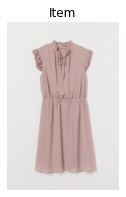

In [540]:
plot_items([article_id], ['Item'])

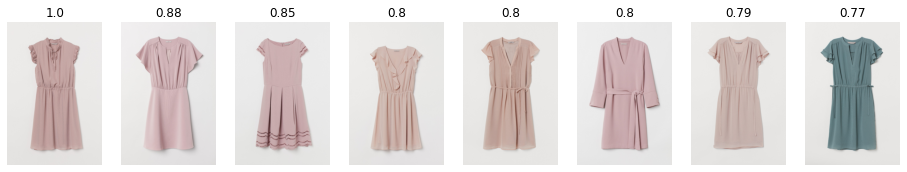

In [541]:
plot_items(combined_rcmnds, combined_scores)

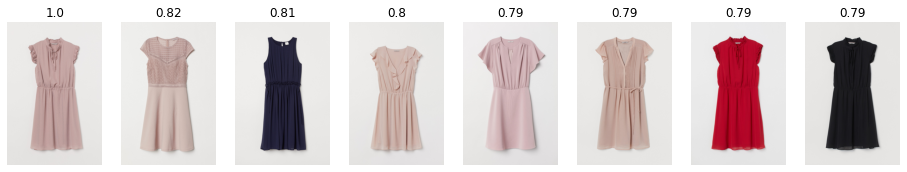

In [542]:
plot_items(image_rcmnds, image_scores)

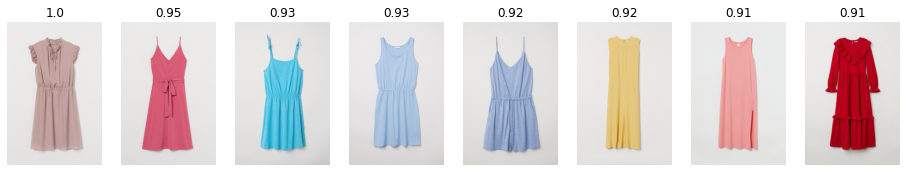

In [543]:
plot_items(tfrs_rcmnds, tfrs_scores)

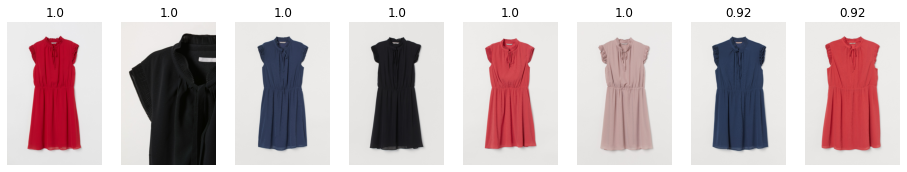

In [544]:
plot_items(text_rcmnds, text_scores)

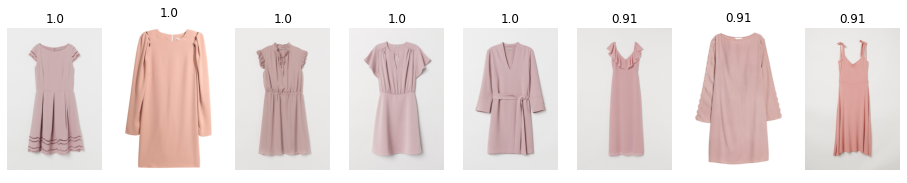

In [545]:
plot_items(feature_rcmnds, feature_scores)

# Recommending items for a customer

In [561]:
customer = customer_all.sample(1).customer_id.values[0]
customer_history = eval(customers_history[customers_history.customer == customer].sequence.values[0])
customer_history = [int(i) for i in customer_history]

combined_customer, customer_tfrs, customer_image, customer_text, customer_feature = get_rand_customer(customer)
(combined_rcmnds, combined_scores), (image_rcmnds, image_scores), (tfrs_rcmnds, tfrs_scores), (text_rcmnds, text_scores), (feature_rcmnds, feature_scores) = get_rcmnds(combined_customer, customer_tfrs, customer_image, customer_text, customer_feature)

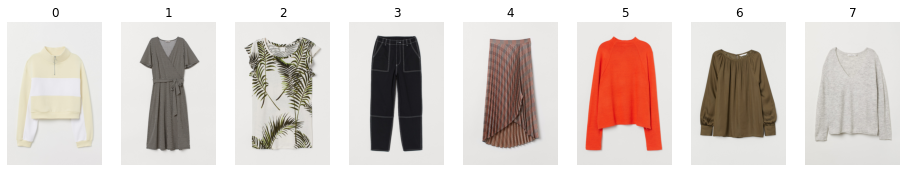

In [562]:
plot_items(customer_history[:8], range(8))

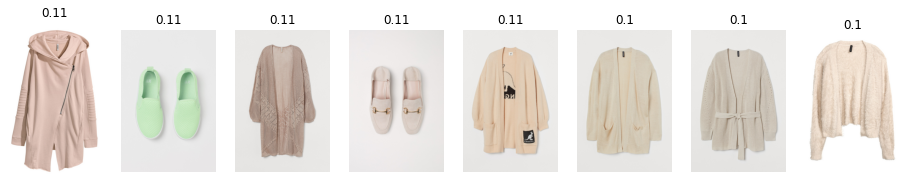

In [563]:
plot_items(combined_rcmnds, combined_scores)

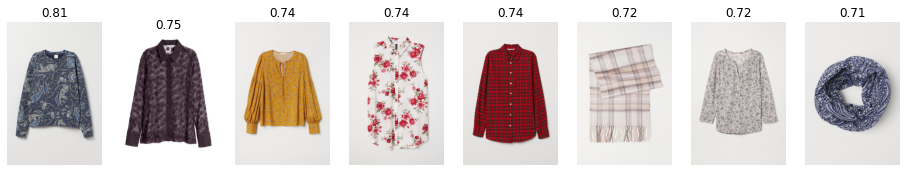

In [564]:
plot_items(image_rcmnds,image_scores)

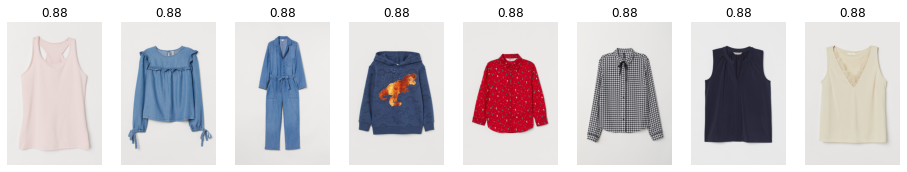

In [565]:
plot_items(tfrs_rcmnds, text_scores)

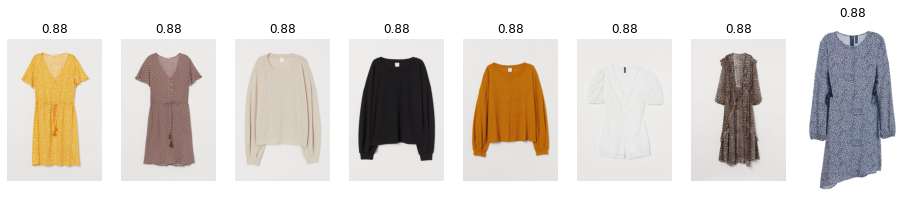

In [566]:
plot_items(text_rcmnds, text_scores)

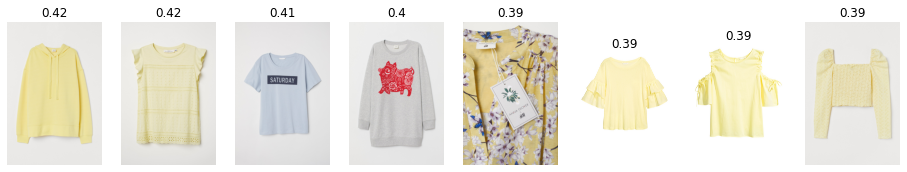

In [567]:
plot_items(feature_rcmnds, feature_scores)

# Recommendations for newly generated customer

In [568]:
new_customer_history = np.random.choice(everthing.article_id.values, size=6, replace=False)

combined_customer, customer_tfrs, customer_image, customer_text, customer = get_new_customer(new_customer_history)
(combined_rcmnds, combined_scores), (image_rcmnds, image_scores), (tfrs_rcmnds, tfrs_scores), (text_rcmnds, text_scores), (feature_rcmnds, feature_scores) = get_rcmnds(combined_customer[1:], customer_tfrs, customer_image, customer_text, customer_feature)

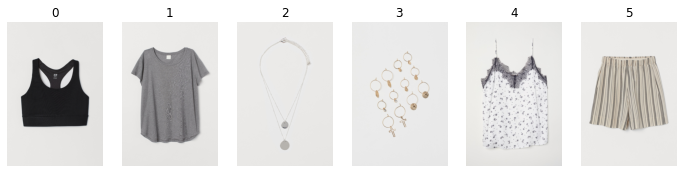

In [569]:
plot_items(new_customer_history[:8], range(8))

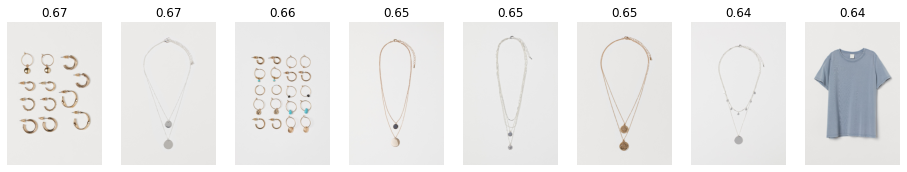

In [570]:
plot_items(combined_rcmnds, combined_scores)

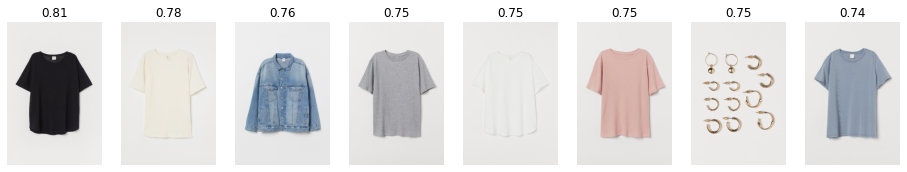

In [571]:
plot_items(image_rcmnds,image_scores)

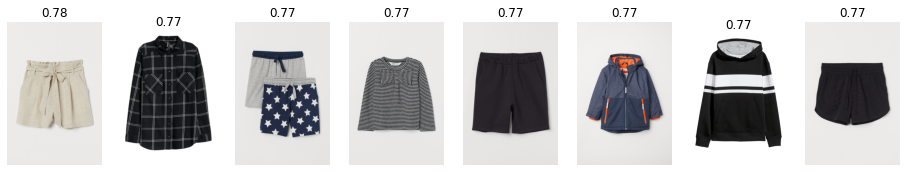

In [572]:
plot_items(tfrs_rcmnds, text_scores)

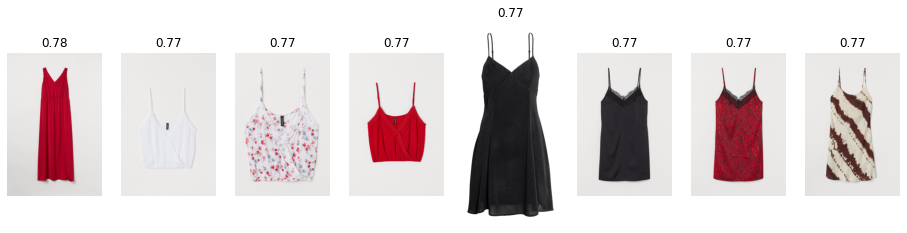

In [573]:
plot_items(text_rcmnds, text_scores)

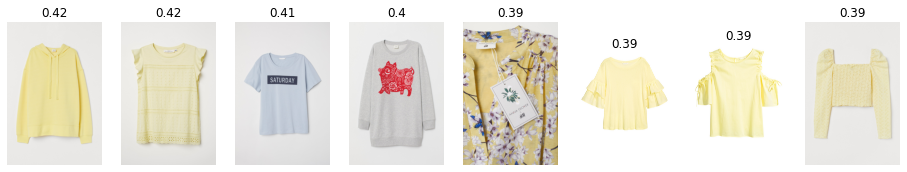

In [574]:
plot_items(feature_rcmnds, feature_scores)